In [1]:
"""@package docstring

SINTEO project
Copyright (C) 2022 ISAE-SUPAERO / ONERA

Description:
The aim of this notebook is to carry out task/memory mapping optimization.
Currently, the objectvies are two minimize the workload variance (increase execution parallelism) 
and minimize the maximum DDR3 memory interference. To do so, the former uses the variance of the tasks exextion time 
and the latter a DDR3 memory interference cost function equation.
Several tasks can be mapped on the same core. Each task/core accepts only one bank. 
Several tasks/cores can point to the same bank.  

The current values present in this notebook is for the heterogenous Keystone II platform by Texas Instruments 
and its associated DDR3 memory controller, e.g., task properties, testing scenarios, DDR3 memory parameters. 


Creation date: 12/7/2021
Last modification date: 10/02/2022
Version: 1.1

Contact:
alfonso.mascarenas-gonzalez@isae-supaero.fr
jean-baptiste.chaudron@isae-supaero.fr
youcef.bouchebaba@onera.fr
frederic.boniol@onera.fr

"""

'@package docstring\n\nDescription:\nThe aim of this notebook is to carry out task/memory mapping optimization.\nCurrently, the objectvies are two minimize the workload variance (increase execution parallelism) \nand minimize the maximum DDR3 memory interference. To do so, the former uses the variance of the tasks exextion time \nand the latter a DDR3 memory interference cost function equation.\nSeveral tasks can be mapped on the same core. Each task/core accepts only one bank. \nSeveral tasks/cores can point to the same bank.  \n\nThe current values present in this notebook is for the heterogenous Keystone II platform by Texas Instruments \nand its associated DDR3 memory controller, e.g., task properties, testing scenarios, DDR3 memory parameters. \n\n\nCreation date: 12/7/2021\nLast modification date: 10/02/2022\nVersion: 1.1\n\n'

In [2]:
#* Import libraries *#


# jMetalPY related (see https://github.com/jMetal/jMetalPy)
###########################################################

from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.algorithm.multiobjective.gde3 import GDE3
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.algorithm.multiobjective.spea2 import SPEA2
from jmetal.algorithm.multiobjective.mocell import MOCell
from jmetal.algorithm.multiobjective.hype import HYPE
from jmetal.algorithm.multiobjective.moead import MOEAD
from jmetal.algorithm.multiobjective.smpso import SMPSO
from jmetal.algorithm.multiobjective.omopso import OMOPSO
from jmetal.algorithm.multiobjective.nsgaiii import (NSGAIII, UniformReferenceDirectionFactory)

from jmetal.operator.mutation import NonUniformMutation
from jmetal.operator import (SBXCrossover, IntegerPolynomialMutation, 
                             PolynomialMutation, DifferentialEvolutionCrossover, UniformMutation)
from jmetal.operator.crossover import IntegerSBXCrossover

from jmetal.core.problem import Problem
from jmetal.core.problem import (IntegerProblem, FloatProblem)
from jmetal.core.problem import (IntegerSolution, FloatSolution)
from jmetal.util.solution import (get_non_dominated_solutions, print_function_values_to_file, print_variables_to_file)
from jmetal.util.neighborhood import C9
from jmetal.util.archive import CrowdingDistanceArchive
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.aggregative_function import Tschebycheff

from jmetal.util.observer import ProgressBarObserver
from scipy.stats import multivariate_normal


# Common libraries
##################

import random # For creating the intial solution
import statistics # For the variance cost function
import copy # For performing deep copies
import math # For floor operations
import matplotlib.pyplot as plt # For plotting the results



In [3]:
# DDR SDRAM Paramaters constant variables
#########################################

CMD_BUSRT_THRESH = 4 # Size of the read and write commands batches (not watermaking policy on the Keystone II platform)
NB_BANKS = 4 # Number of internal SDRAM banks (Keystone II platform supports 8)
BL = 8 # Number of columns that can be accessed during a read or a write
CL = 11 # Elapsed time since the execution of a read command and the arrival of data
WL = 8 # Elapsed time since the execution of a write command and the arrival of data
t_CCD = BL/2 # Minimum time to leave between two CAS commands (read or write)
t_WR = 12 # Time from the last burst write cycle until a precharge can be issued to the same bank
t_RTP = 6 # Delay between a read command execution and a row bank precharge
t_WTR = 6 # Write to read turnaround time
t_RP = 11 # Deactivation time of an opened row of a bank (precharge command)
t_RRD = 6 # Minimum time separation of two consecutive active commands to different banks
t_FAW = 24 # Time window where maximum four consecutive active commands can be issued
t_RCD = 11 # Activation time of a closed row of a bank (active command)


# Conversion constant variables
###############################

DDR_CORE_FREQ_CONV = 1.5 # Frequency conversion from the DDR memory controller to the cores frequency (core_freq / controller_freq)

In [4]:
class PE():

   def __init__(self, ID: int, category: int, memory: int, load: int):
        """Constructor for the class PE. Initializes the Processing Elements (PE) properties. 

        Parameters:
        ID (int): Identification of the PE to be mapped.
        category (int): PE type.
        memory (int): Total memory space used by all the tasks mapped to this PE. Units: Bytes
        load (int): Total worst-case execution time in isolation of all the tasks mapped to this PE. Units: cycles

        Returns:
        Nothing 

        """
        self.id = ID
        self.category = category # The group to which the PE belongs (ARM pack, DSP...). ARM = 0; DSP = 1
        self.memory = memory # Total memory on core after tasks inclusion
        self.load = load # Total load on core after tasks inclusion
   
   def reset_PE(self):
        """Resets the PE properties. 

        Parameters:
        None

        Returns:
        Nothing 

        """
        self.memory = 0
        self.load = 0

    
class Task():
    
   def __init__(self, ID: int, memory: int, load: int, access: int, SP: float, LP: float, ACOR: float, PE: int, bank: int, row_switches: int, period: int):
        """Constructor for the class Task. Initializes the task properties. 

        Parameters:
        ID (int): Identification of the task to be mapped.
        memory (int): Memory space required by the task. Units: Bytes
        load (int): Worst-case execution time in isolation. Units: cycles
        access (int): Maximum number of DDR memory accesses in isolation. 
        SP (float): Proportion of stores of the DDR memory accesses. [0,1]
        LP (float): Proportion of loads of the DDR memory accesses. [0,1]
        ACOR (float): Average Commands per Opened Row during a maximum interference scenario
        PE (int): PE identification
        bank (int): Bank identification
        row_switches (int): Number of row switches in isolation
        period (int): Execution period of the task. Units: cycles

        Returns:
        Nothing 

       """
        self.id = ID
        self.memory = memory
        self.load = load
        self.access = access
        self.SP = SP
        self.LP = LP  
        self.ACOR = ACOR
        self.PE = PE
        self.bank = bank
        self.row_switches = row_switches
        self.period = period

        
        
class Platform():

   def __init__(self, nb_PE: int, nb_banks: int, nb_tasks: int):
        """Constructor for the class Platform. Initializes the platform properties. 

        Parameters:
        nb_PE (int): Total number of Processing Elements (PEs) on the platform
        nb_banks (int): Total number of banks on the DDR memory controller of the platform
        nb_tasks (int): Total number of tasks to be used on the platform 

        Returns:
        Nothing 

        """        
        self.nb_PE = nb_PE
        self.nb_banks = nb_banks
        self.nb_tasks = nb_tasks
        

In [5]:
def task_ua_isolation(ts_list, ts_ua_index):
    """Filters out the those tasks running on the same core than the task under analysis 

    Parameters:
    task_list (list): List with all the tasks involved
    ts_ua_index (unsigned): Index of the task to analyze
    
    Returns:
    list: List of tasks with the interfereing tasks on the same core than the task under analysis removed  

    """
    
    new_list = []
    
    for cnt in range(len(ts_list)):
        if cnt != ts_ua_index and ts_list[cnt].PE == ts_list[ts_ua_index].PE:
            continue
        new_list.append(ts_list[cnt])
        
    return new_list 

def split_by_PE(task_list):
    """Divides the tasks into groups as function of its PEs. 

    Parameters:
    task_list (list): List with all the tasks involved

    Returns:
    list: List of task sublists by PE  

    """
    
    new_list = []
    for i in range(ptf.nb_PE):
        new_list.append([])
        
    for j in range(len(task_list)):
        new_list[task_list[j].PE].append(task_list[j])

    return new_list


def get_number_of_external_banks_used(tasks_list):
    """Calculates the number of banks other than the one of the task under anlysis. 

    Parameters:
    task_list (list): List with all the tasks involved

    Returns:
    double: The total store or load proportion of intra-bank interfering tasks
    double: The total store or load proportion of inter-bank interfering tasks

   """
    banks_list = [0] * ptf.nb_banks

    for j in range(len(tasks_list)): 
        banks_list[tasks_list[j].bank] = 1    
            
    return (sum(banks_list)-1)

In [6]:
global ptf

def total_access_proportion(task_list, task_ua_index, instr): 
    """Calculates the global store or load proportion from the task under analysis by considering all the tasks.
    It differentiates between intra-bank and inter-bank store or load proportion. 

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task to analysis
    instr (string): To select either the store or load proportion to calculate. 
                    'SP' for the store proportion
                    'LP' for the load proportion

    Returns:
    double: The total store or load proportion of intra-bank interfering tasks
    double: The total store or load proportion of inter-bank interfering tasks

   """
        
    total_proportion_intra = 0
    total_proportion_inter = 0
    
    proportion_list_intra = []
    proportion_list_inter = []

    if instr == 'SP':
        for i in range(len(task_list)):
            if i == task_ua_index:
                continue
            if task_list[i].bank == task_list[task_ua_index].bank:
                proportion_list_intra.append(task_list[i].SP)
            else:
                proportion_list_inter.append(task_list[i].SP)

    elif instr == 'LP':   
        for i in range(len(task_list)):
            if i == task_ua_index:
                continue
            if task_list[i].bank == task_list[task_ua_index].bank:
                proportion_list_intra.append(task_list[i].LP)
            else:
                proportion_list_inter.append(task_list[i].LP)
                
    if len(proportion_list_intra) != 0:
        total_proportion_intra = sum(proportion_list_intra) / len(proportion_list_intra)
    
    if len(proportion_list_inter) != 0:
        total_proportion_inter = sum(proportion_list_inter) / len(proportion_list_inter)
            
    return total_proportion_intra, total_proportion_inter 


def PGNCL(task_list, task_ua_index):
    """Calculates the number of command in the queue line that execute before the selected task from a task list 
    considering periodic conditions and distinguishing between intra-bank and inter-bank interference

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task under analysis

    Returns:
    double: The number of worst-case intra-bank interfering accesses
    double: The number of worst-case inter-bank interfering accesses

   """
    ncl_intra = 0;
    ncl_inter = 0;

    task_ua = task_list[task_ua_index] 
    
    # Iterate through all the interfering tasks and compute the number of access interfering task_ua
    for t in range(len(task_list)):
        if t == task_ua_index:
            continue
           
        if task_list[task_ua_index].bank == task_list[t].bank:
            ncl_intra = ncl_intra + task_list[t].access * RIE(task_list, task_ua_index, t)
        else:
            ncl_inter = ncl_inter + task_list[t].access * RIE(task_list, task_ua_index, t)

    return ncl_intra, ncl_inter 

def CBS(nb_concurren_banks):
    """ Computes the wort-case size of the read/write bacthes, i.e., the Command Batch Size (CBS)  

    Parameters:
    nb_concurren_banks (int): Number of concurrent banks being used

    Returns:
    int: The command bacth size

   """
    cbs = min(nb_concurren_banks, CMD_BUSRT_THRESH);
    return cbs 

def ACOR(task_list, ts_index):
    """ Returns the Average Commands per Opened Row (ACOR) from the selected task

    Parameters:
    task_list (list): List with all the tasks involved
    ts_index (unsigned): Index of the task to obtain the data from

    Returns:
    double: The RTER value

   """
    return task_list[ts_index].ACOR 


def RIE(task_list, task_ua_index, taks_j_index):
    """ Returns the Relative Interference Exposition (RIE) from the given tasks, 
    i.e., the amount of time a task can affect another assuming a uniform distribution

    Parameters:
    task_list (list): List with all the interfering tasks involved
    task_ua_index (unsigned): Task under analisys index
    taks_j_index (unsigned): The index of an interfering task 

    Returns:
    double: The RIE value

   """

    task_ua = task_list[task_ua_index] 
    task_j = task_list[taks_j_index]

    # (1) Calculate the number of task_j executions that affect the task_ua. 
    # Monoperiodic cases ignore this (task_ua.load < task_j.period).
    # (2) Calculate the proportion of time task_j affects by task_ua within an single execution
    # task_ua can't be affected more than one entirely time by task_j within an single execution, therefore limited to 1.
    RIE = \
    ( \
     math.floor(task_ua.load / task_j.period)  # (1)
     + min( (task_ua.load - math.floor(task_ua.load/task_j.period) * task_j.period)/task_j.load, 1 )  # (2)
    )

    return RIE 

def calculate_row_switches_quantity(task_list, task_ua_index):
    """Calculates the number of row switched that the task under anlysis suffers from 
    the interfering tasks pointing to the same and external banks (intra and inter)

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (unsigned): Index of the task to analyze

    Returns:
    double: The number of worst-case intra-bank row switches
    double: The number of worst-case inter-bank row switches

   """
    rs_intra = 0;
    rs_inter = 0;
    task_ua = task_list[task_ua_index] 

    # Check for all banks in the platform
    for bank_id in range(NB_BANKS):
        nb_cores = 0
        rs_inter_bank = 0
        
        # Compute the number of cores pointing to bank bank_id
        for t in range(len(task_list)):
            if task_list[t].bank == bank_id:
                nb_cores = nb_cores + 1          
        
        # Check how many accesses affect the task under analysis
        for t in range(len(task_list)):
            if t == task_ua_index:
                continue
            if task_list[t].bank != bank_id:
                continue
            
            # Intra-bank interfering accesses
            if task_list[t].bank == task_ua.bank:
                rs_intra = rs_intra + min(task_list[t].access * RIE(task_list, task_ua_index, t)/ACOR(task_list, t), \
                                          task_ua.access/ACOR(task_list, task_ua_index))
            # Inter-bank interfering accesses    
            else:
                # Affected by the intrinsic interfering task row switches
                if(nb_cores == 1):
                    rs_inter_bank = task_list[t].row_switches
                # Number of times an interfering task row switch is produced by opening a closed row forced by another interfering task to the same bank   
                else:
                    rs_inter_bank = rs_inter_bank + task_list[t].access * RIE(task_list, task_ua_index, t)/ACOR(task_list, t)
         
        rs_inter = rs_inter + min(task_ua.access/ACOR(task_list, task_ua_index), rs_inter_bank)
        

    return  (rs_intra, rs_inter) 

def interference_cost_calculation(task_list, task_ua_index):
    """ Returns the Relative Interference Exposition (RIE) from the given tasks

    Parameters:
    task_list (list): List with all the tasks involved
    task_ua_index (int): Task under analisys index from the task list

    Returns:
    double: The DDR interference cost for the the task under analysis

   """

    taks_ua = task_list[task_ua_index]
    nb_external_banks = get_number_of_external_banks_used(task_list)
    nb_used_banks = nb_external_banks + 1
    
    # Compute the number of intra-bank and inter-bank interfering accesses 
    PGNCL_intra, PGNCL_inter = PGNCL(task_list, task_ua_index)

    # Compute the turnaround write and read transmission cost for intra-bank and inter-bank interference cases
    WT_intra = WL + BL/2 + t_WTR
    RT_intra = CL + BL/2 + 2
    WT_inter = WL + BL/2 + t_WTR
    RT_inter = CL + BL/2 + 2 - WL 
        
    # Compute the total Store and Load proportion
    SPT_intra, SPT_inter = total_access_proportion(task_list, task_ua_index, 'SP')
    LPT_intra, LPT_inter = total_access_proportion(task_list, task_ua_index, 'LP')
    
    # Caclulate the DDR3 interfering cost
    cmd_cost_intra = (1/CBS(nb_used_banks))*PGNCL_intra*(SPT_intra*WT_intra + LPT_intra*RT_intra) \
                     + (1 - 1/CBS(nb_used_banks))*PGNCL_intra*BL/2
    cmd_cost_inter = (1/CBS(nb_used_banks))*PGNCL_inter*(SPT_inter*WT_inter + LPT_inter*RT_inter) \
                     + (1- 1/CBS(nb_used_banks))*PGNCL_inter*BL/2
    
    # Calculate the intra-bank row switch cost
    row_switch_cost_intra = max(t_RTP, t_WR) + t_RP + t_RCD + max(WL, CL)
    
    # Calculate the inter-bank row switch cost
    if nb_external_banks < 4:
        row_switch_cost_inter = 1 + t_RRD 
    else:
        row_switch_cost_inter = 1 + t_FAW - 3*t_RRD

    #Calculate the number of row switches and cost
    rs_intra, rs_inter = calculate_row_switches_quantity(task_list, task_ua_index)
    total_row_sw_cost_intra = rs_intra*row_switch_cost_intra
    total_row_sw_cost_inter = rs_inter*row_switch_cost_inter
    
    # Interference cost
    impact = cmd_cost_intra + cmd_cost_inter + total_row_sw_cost_intra + total_row_sw_cost_inter    
    
    
    return impact



In [7]:
def virtual_task_creation(ts_list, ts_ua_index):
    """Creates the virtual task for a given task from a task list. 
    The task under analysis is isolated from the interfering tasks running on its PE.
    The interfering tasks on other cores are merge, creating a virtual task, leaving one task per core.

    Parameters:
    ts_list (list): List with all the tasks involved
    ts_ua_index (unsigned): Index of the task to analyze

    Returns:
    list: The virtual task list
    int: New task under analysis index

   """
    
    # Remove those interfereing tasks running on the same core than the task under analysis 
    ts_ua_cleaned_ls = task_ua_isolation(ts_list, ts_ua_index)
    # Split the task list in core groups 
    ts_ls_split = split_by_PE(ts_ua_cleaned_ls)
    # Declare a variable for the new position index of the task under analysis once the final combination task list is created
    new_ts_ua_index = 0
    # Remove empty PEs from the split list
    ts_ls_split_cleaned = [ls for ls in ts_ls_split if ls != []]
    # List with one task per core. Interfering tasks are merged.
    virtual_task_list = []
    
    # Create the task list by merging tasks on the same core
    for i in range(len(ts_ls_split_cleaned)): # For each core 
    
        virtual_task = Task(0,0,0,0,0,0,0,0,0,0,0)
        
        # Virtual task creation from the merge of the tasks on the same PE
        for j in range(len(ts_ls_split_cleaned[i])): # For each task on core 
            virtual_task.id = ts_ls_split_cleaned[i][0].id
            virtual_task.memory = virtual_task.memory + ts_ls_split_cleaned[i][j].memory 
            virtual_task.load = virtual_task.load + ts_ls_split_cleaned[i][j].load
            virtual_task.access = virtual_task.access + ts_ls_split_cleaned[i][j].access 
            virtual_task.SP = virtual_task.SP + ts_ls_split_cleaned[i][j].SP
            virtual_task.LP = virtual_task.LP + ts_ls_split_cleaned[i][j].LP
            virtual_task.ACOR = virtual_task.ACOR + ts_ls_split_cleaned[i][j].ACOR
            virtual_task.PE = ts_ls_split_cleaned[i][0].PE
            virtual_task.bank = ts_ls_split_cleaned[i][0].bank # Only possible when doing a core-bank map (not in task-bank)
            virtual_task.row_switches = virtual_task.row_switches + ts_ls_split_cleaned[i][j].row_switches
            virtual_task.period = ts_ls_split_cleaned[i][j].period
                       
        virtual_task.SP = virtual_task.SP/len(ts_ls_split_cleaned[i])
        virtual_task.LP = virtual_task.LP/len(ts_ls_split_cleaned[i])
        virtual_task.ACOR = virtual_task.ACOR/len(ts_ls_split_cleaned[i])

        virtual_task_list.append(virtual_task) 
        
    # Task under analysis index
    for j in range(len(virtual_task_list)): 
        if virtual_task_list[j].id == ts_ua_index:
            new_ts_ua_index = j
            break

    return [virtual_task_list, new_ts_ua_index]


def DDR_interference_recursive_cost_function(task_list, ts_ua_index):
    """Calculates recursively the DDR interference cost for all the task from a task list

    Parameters:
    task_list (list): List with the original tasks involved
    ts_ua_index (unsigned): Index of the task to analyze
    
    Returns:
    double (list): The worst DDR3 interference cost for the all the tasks

   """
    
    # Obtain the virtual set of tasks for the interference calculation
    [virtual_task_list, virtual_task_ua_index] = virtual_task_creation(task_list, ts_ua_index)
    
    # Number of times we are looping to leave the model converge sufficiently. 
    # Values 4 and 5 are already good enough for the tested scenarios. 
    ITER = 8 
    
    task_list_load_temp = [0]*len(virtual_task_list)
    task_list_iter = copy.deepcopy(virtual_task_list) # To keep the task values outcome at the end of an iteration

    # Start the recursive calculation of the interference cost.
    # Alternatively to ITER, an infinite loop can be used, analyze the last measurements to see if it converges and return
    for j in range(ITER):
        
        # Calculate the new execution time for a given task considering the interference from other tasks
        for i in range(len(virtual_task_list)):
            # Calculate interference and add it to the original value considering the clock frequency difference
            new_WCET = virtual_task_list[i].load + DDR_CORE_FREQ_CONV*interference_cost_calculation(task_list_iter, i)
            task_list_load_temp[i] = new_WCET
        
        # Update tasks properties for the next interation
        for i in range(len(task_list_iter)):
             task_list_iter[i].load = task_list_load_temp[i]

    # Caclulate the DDR3 interfering cost
    cost = task_list_iter[virtual_task_ua_index].load - virtual_task_list[virtual_task_ua_index].load

    return cost 


In [8]:
global ptf

class OptimizationProblem2D(FloatProblem):

    def __init__(self, task_properties_list: list, PE_list: list):
        """ Constructor for the class OptimizationProblem2D. 
        It initializes the objectives, constrains, variables, upper and lower bounds, 
        optimization direction

        Parameters:
        task_properties_list (list): List with all the properties of the tasks to map
        PE_list (list): List with the PEs of the platform 

        Returns:
        Nothing 

        """
        super(OptimizationProblem2D, self).__init__()
        
        self.task_properties_list = task_properties_list

        self.mapped_task_list = []
        self.task_interference_cost_list = []
        
        # Create the task list used for the mapping process
        for i in range(len(self.task_properties_list)):
            self.mapped_task_list.append(Task(i, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0))

        self.my_PEs = PE_list
        self.number_of_PEs = len(self.my_PEs)

        self.number_of_objectives = 2
        self.number_of_variables = len(self.mapped_task_list) + len(self.my_PEs) # Number of tasks (x times the allocation memory mapping). 
                                                                    #Plus the number of cores in order to do the core-bank mapping
        self.number_of_constraints = len(self.mapped_task_list)

        self.number_of_banks = NB_BANKS;

        self.lower_bound = []
        self.upper_bound = []
        
        # Bounds for Task mapping on cores
        for i in range(len(self.mapped_task_list)):
            self.lower_bound.append(0)
            self.upper_bound.append(self.number_of_PEs) # Number of PE

        # Bounds for Memory mapping on cores
        for i in range(len(self.my_PEs)):
            self.lower_bound.append(0)
            self.upper_bound.append(self.number_of_banks) # Number of banks

        # Minimize or Maximize objective
        self.obj_directions = [self.MINIMIZE, self.MINIMIZE]

        # Tag of the objective to optimize
        self.obj_labels = ['Load Variance', 'Maximum Interference']
         
    
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        """ Associates the task/memory mapping solution for the current algorithm iteration 
        with its objectives cost and constraints

        Parameters:
        solution (list): Task/memory mapping solutions for the current algorithm iteration

        Returns:
        FloatSolution: The found solution with the updated proeperties  

        """
        
        # Apply the modulus to avoid out of bounds solutions due to randomization in the algorithms 
        for index in range(self.number_of_variables):
            solution.variables[index] = int(round(solution.variables[index]))%self.upper_bound[index] # Core/Bank mapping    

        # Reset the PE properties value before evaluating 
        for index in range(self.number_of_PEs):
            self.my_PEs[index].reset_PE() 

        # Set the tasks characteristics according to the task/memory map, 
        # i.e., considering the PE where the task is being executed  
        for index in range(len(self.mapped_task_list)):
            self.mapped_task_list[index].PE = solution.variables[index];
            self.mapped_task_list[index].memory = task_list[index].memory
            self.mapped_task_list[index].load = task_list[index].load[self.my_PEs[solution.variables[index]].category]
            self.mapped_task_list[index].access = task_list[index].access[self.my_PEs[solution.variables[index]].category]
            self.mapped_task_list[index].SP = task_list[index].SP[self.my_PEs[solution.variables[index]].category]
            self.mapped_task_list[index].LP = task_list[index].LP[self.my_PEs[solution.variables[index]].category]
            self.mapped_task_list[index].ACOR = task_list[index].ACOR[self.my_PEs[solution.variables[index]].category]
            self.mapped_task_list[index].row_switches = task_list[index].row_switches[self.my_PEs[solution.variables[index]].category]
            self.mapped_task_list[index].period = task_list[index].period

        # Compute the total memory and execution time (load) for each PE
        for index in range(len(self.mapped_task_list)):
            self.my_PEs[solution.variables[index]].memory = (
                                                           self.mapped_task_list[index].memory 
                                                           + self.my_PEs[solution.variables[index]].memory
                                                           )
            self.my_PEs[solution.variables[index]].load = (
                                                         self.mapped_task_list[index].load 
                                                         + self.my_PEs[solution.variables[index]].load
                                                         )
        # Set the tasks bank property as function of the task-core map and core-bank map given by the solution  
        for core_bank in range(len(self.my_PEs)):
            for index in range(len(self.mapped_task_list)):
                if self.mapped_task_list[index].PE == core_bank:
                    self.mapped_task_list[index].bank = \
                    solution.variables[core_bank+len(self.mapped_task_list)];  # task-core map offset

        # Return the cost for the chosen objectives considering the current task/memory map 
        solution.objectives = self.select_objective(solution)  
        
        # Apply the constraints to the solution. Currently, the constraints are deadline related. 
        self.__evaluate_constraints(solution)

    
        return solution
    

    def __evaluate_constraints(self, solution: FloatSolution) -> None:
        """ Creates the constraints for the current task/memory mapping solution

        Parameters:
        solution (FloatSolution): Current solution generated by the algorithm

        Returns:
        Nothing  

        """
        safe_margin = 0

        # Computes the solution constraints. 
        # For each task it is calculates that it does not exceed its deadline which is equivalent to its period.
        # For this purpose, we use its interference cost, the total load executing by the PE (core) in 
        # isolation conditions and a safety margin if necessary
        for i in range(len(self.mapped_task_list)):
            solution.constraints[i] = (self.mapped_task_list[i].period 
                                     - self.task_interference_cost_list[i] 
                                     - self.my_PEs[solution.variables[i]].load
                                     - safe_margin
                                     )
    
    def get_name(self) -> str:
        return 'Task/Memory Mapping Problem'

    def create_solution(self) -> FloatSolution:
        """ Creates the initial solution and randomly sets its variables values between the given bounds

        Parameters:
        None

        Returns:
        FloatSolution: Initialized solution object  

        """

        new_solution = FloatSolution(lower_bound = self.lower_bound,
                                       upper_bound = self.upper_bound,
                                       number_of_constraints=self.number_of_constraints,
                                       number_of_objectives=self.number_of_objectives)
        
        # For each variable in the solution, randomly set its value respecting the bounds
        new_solution.variables = \
            [int(random.randint(self.lower_bound[i], self.upper_bound[i]))
             for i in range(self.number_of_variables)] 
            
            
        return new_solution

    
    def select_objective(self, solution: FloatSolution):
        """ Selects the objectives for whom the cost are calculated

        Parameters:
        solution (FloatSolution): Current solution generated by the algorithm

        Returns:
        double: Objectives cost list 

        """
        objective_list = []
        # Iterate through all the objectives (2 in the current configuration)
        for i in range(len(self.obj_labels)):
            pe_accum = []
            if self.obj_labels[i] == "Memory Variance":
                for j in range(len(self.my_PEs)):
                    pe_accum.append(self.my_PEs[j].memory)
                objective_list.append(statistics.variance(pe_accum))      
            elif self.obj_labels[i] == "Load Variance":
                for j in range(len(self.my_PEs)):
                    pe_accum.append(self.my_PEs[j].load)
                objective_list.append(statistics.variance(pe_accum))
            elif self.obj_labels[i] == "Maximum Interference": 
                self.task_interference_cost_list = []
                for j in range(len(self.mapped_task_list)):
                    self.task_interference_cost_list.append(DDR_interference_recursive_cost_function(self.mapped_task_list, j))
                objective_list.append(max(self.task_interference_cost_list))
            elif self.obj_labels[i] == "Deadline Margin": 
                self.task_interference_cost_list = []
                margin_list = []
                for j in range(len(self.mapped_task_list)):
                    self.task_interference_cost_list.append(DDR_interference_recursive_cost_function(self.mapped_task_list, j))
                    # Deadline = Period is assumed. If not, a deadline property must be created in the Task class 
                    margin_list.append(self.mapped_task_list[j].period 
                                       - self.task_interference_cost_list[j]
                                       - self.my_PEs[solution.variables[i]].load
                                      ) 
                objective_list.append(min(margin_list))  
            else: 
                objective_list.append(0)  

        return objective_list


In [9]:
def return_algorithm(problem, algorithm_tag):
    """ Configures the algorithm to use for exploring the task/memory solutions space

    Parameters:
    problem (problem): The problem to solve by the algorithm
    algorithm_tag (string): Tag of the algorithm to configure 

    Returns:
    algorithm: The configured algorithm to be run 

    """
    
    max_evaluations = 35000 
    population_size=2000
    offspring_population_size=2000


    # Indicator Based Evolutionary Algorithm (IBEA)
    if algorithm_tag == "IBEA":
        algorithm = IBEA(
            problem=problem,
            kappa=1.,
            population_size=population_size,
            offspring_population_size=offspring_population_size,
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            crossover=SBXCrossover(probability=1.0, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )
        
    # Non-dominated Sorting Genetic Algorithm II (NSGA-II)
    if algorithm_tag == "NSGA-II":
        algorithm = NSGAII(
            problem=problem,
            population_size=population_size,
            offspring_population_size=offspring_population_size,
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            crossover=SBXCrossover(probability=1.0, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )
        
    # Non-dominated Sorting Genetic Algorithm III (NSGA-III)
    if algorithm_tag == "NSGA-III":    
        algorithm = NSGAIII(
        problem=problem,
        population_size=population_size,
        reference_directions=UniformReferenceDirectionFactory(3, n_points=91),
        mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
        crossover=SBXCrossover(probability=1.0, distribution_index=30),
        termination_criterion=StoppingByEvaluations(max_evaluations)
        )
        
    # Strength Pareto Evolutionary Algorithm (SPEA2)
    if algorithm_tag == "SPEA2":
        algorithm = SPEA2(
            problem=problem,
            population_size=(int)(population_size/2),
            offspring_population_size=(int)(offspring_population_size/2),
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            crossover=SBXCrossover(probability=1.0, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )
        
    # Generalized Differential Evolution (GDE3)
    if algorithm_tag == "GDE3":
        algorithm = GDE3(
            problem=problem,
            population_size=population_size,
            cr=0.5,
            f=0.5,
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )
        
    # MultiObjective Cellular genetic algorithm (MOCell)
    if algorithm_tag == "MOCell":    
        algorithm = MOCell(
            problem=problem,
            population_size=population_size,
            neighborhood=C9(10, 10),
            archive=CrowdingDistanceArchive(100),
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            crossover=SBXCrossover(probability=1.0, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )
        
    # Fast Hypervolume-Based Many-Objective Optimization algorithm (HypE)
    if algorithm_tag == "HYPE": 
        reference_point = IntegerSolution(lower_bound = problem.lower_bound,
                                        upper_bound = problem.upper_bound,
                                        number_of_constraints=0,
                                        number_of_objectives=problem.number_of_objectives)

        reference_point.objectives = [1, 1]  # Mandatory for HYPE

        algorithm = HYPE(
            problem=problem,
            reference_point=reference_point,
            population_size=population_size,
            offspring_population_size=offspring_population_size,
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            crossover=SBXCrossover(probability=1.0, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )

    # Multi-objective Evolutionary Algorithm by Decomposition (MOEAD)
    if algorithm_tag == "MOEAD": 
        algorithm = MOEAD(
            problem=problem,
            population_size=population_size,
            crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            aggregative_function=Tschebycheff(dimension=problem.number_of_objectives),
            neighbor_size=20,
            neighbourhood_selection_probability=0.9,
            max_number_of_replaced_solutions=2,
            weight_files_path='resources/MOEAD_weights',
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )

    
    max_evaluations = 35000
    swarm_size = 2000
    
    # Speed-constrained Multi-objective PSO (SMPSO)
    if algorithm_tag == "SMPSO": 
        algorithm = SMPSO(
            problem=problem,
            swarm_size=swarm_size,
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            leaders=CrowdingDistanceArchive(swarm_size),
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )
        
    # Multi-objective particle swarm optimizer (MOPSO)
    if algorithm_tag == "OMOPSO": 
        algorithm = OMOPSO(
            problem=problem,
            swarm_size=swarm_size,
            epsilon=0.0075,
            uniform_mutation=UniformMutation(probability=1.0 / problem.number_of_variables, perturbation=0.5),
            non_uniform_mutation=NonUniformMutation(1.0 / problem.number_of_variables, perturbation=0.5,
                                                    max_iterations=int(max_evaluations)),
            leaders=CrowdingDistanceArchive(swarm_size),
            termination_criterion=StoppingByEvaluations(max_evaluations)
        )
    
    
    # Shows the status of the computation when running the algorithm
    progress_bar = ProgressBarObserver(max=max_evaluations)
    algorithm.observable.register(progress_bar)
    
    return algorithm

In [10]:
def export_results(data_list, algorithm_tag):
    """ Exports the variables set and cost of the task/memory mapping solutions for every run algorithm in CSV format

    Parameters:
    data_list (list): List with the solutions of every used algorithm 
    algorithm_tag (string list, string): Tag(s) of the used algorithms 

    Returns:
    Nothing

    """
    
    tag = ""
    
    # Iterate through the different algorithms soutions
    for i in range(len(data_list)): 
        if type(algorithm_tag) == list:
            tag = algorithm_tag[i]
        else:
            tag = algorithm_tag
            
        # save to files
        print_function_values_to_file(data_list[i], './FUN/'+'FUN.'+tag+'.nonDominated.csv')
        print_variables_to_file(data_list[i], './VAR/'+'VAR.'+tag+'.nonDominated.csv')


In [11]:
def draw_2Dgraphs(data_cummulative, legend_code, axis_labels, enable_notes, file_name):
    """ Draws and exports the task/memory mapping solutions figure 

    Parameters:
    data_cummulative (list): List with the solutions list(s) to display
    legend_code (string list): List with the legend tag for each solution list 
    axis_labels (string list): List with the X and Y axis name
    enable_notes (boolean): Enable the tag value for each solution
    file_name (string): Name of the graph file to save

    Returns:
    Nothing

   """
    
    mark_code = ['s', 'D', 'o', 'v', '^', '<', '>', '*']
    color_code = ['blue', 'red', 'green', 'darkorange', 'crimson', 'gold', 'indigo', 'black']
    legend = ""
    
    fig = plt.figure()
    for i in range(len(data_cummulative)): 
        if type(legend_code) == list:
            legend = legend_code[i]
        else:
            legend = legend_code
        data = []
        for solution in data_cummulative[i]:
            data.append(solution.objectives)
        for j in range(len(data)):   
            if j == len(data)-1:
                plt.plot(data[j][0], data[j][1], color=color_code[i], marker=mark_code[i], label=legend)
            else:    
                plt.plot(data[j][0], data[j][1], color=color_code[i], marker=mark_code[i])
                

            label = "(" + "{:0.2e}".format(data[j][0]) + "," + "{:0.2e}".format(data[j][1]) + ")"

            if enable_notes == 1:
                plt.annotate(label, # this is the text
                             (data[j][0],data[j][1]), # this is the point to label
                             textcoords="offset points", # how to position the text
                             xytext=(0,10), # distance from text to points (x,y)
                             ha='center', # horizontal alignment can be left, right or center
                             size=5) 

    plt.legend()
    fig.suptitle('Task mapping on platform cores', fontsize=16)
    plt.xlabel(axis_labels[0], fontsize=14)
    plt.ylabel(axis_labels[1], fontsize=14)
    plt.savefig('./Graphs/'+file_name+'.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [12]:
global PE_list

def solutions_exploration(task_list, algorithm_id_tag):
    """ Explore all the task/memory mapping solutions according to the selected algorithm 

    Parameters:
    task_list (list): List with all the tasks involved
    algorithm_id_tag (string): Tag of the algorithm to use for finding the solutions 

    Returns:
    FloatSolution: Nondominated solutions for the selected algorithm

    """    
    # Create a list for storing both type of solutions, unfiltered and nondominated solutions
    solutions_unfiltered_nondominated = []
    
    # Create problem environment
    problem = OptimizationProblem2D(task_list, PE_list)

    # Set and run algorithm
    algorithm = return_algorithm(problem, algorithm_id_tag)
    algorithm.run()   
    solutions = algorithm.get_result()
    
    # Save unfiltered solutions 
    solutions_unfiltered_nondominated.append(solutions)

    solutions_unfiltered_nondominated_tag_list = []
    solutions_unfiltered_nondominated_tag_list.append(algorithm_id_tag+": All")
    solutions_unfiltered_nondominated_tag_list.append(algorithm_id_tag+": Nondominated")
    
    # Save nondominated solutions 
    solutions_unfiltered_nondominated.append(get_non_dominated_solutions(solutions)) 
    
    # Draw and export the graph with unfiltered and nondominated solutions
    draw_2Dgraphs(solutions_unfiltered_nondominated, solutions_unfiltered_nondominated_tag_list,
                  problem.obj_labels, 0, algorithm_id_tag+"_merged")
    
    # Export the nondominated results
    export_results(solutions_unfiltered_nondominated, (algorithm_id_tag+"_merged"))
    
    # Return nondominated solutions
    return solutions_unfiltered_nondominated[1]  

Progress: 36000it [09:39, 62.07it/s]                                                                                   


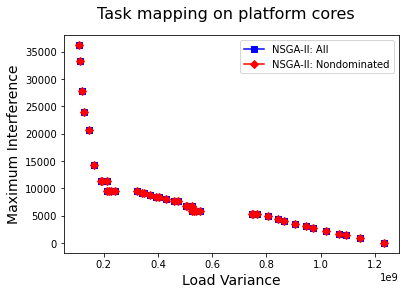

2022-03-04 10:39:36,613 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.NSGA-II_merged.nonDominated.csv
2022-03-04 10:39:36,635 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.NSGA-II_merged.nonDominated.csv
2022-03-04 10:39:36,666 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.NSGA-II_merged.nonDominated.csv
2022-03-04 10:39:36,666 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.NSGA-II_merged.nonDominated.csv
Progress: 100%|#################################################################| 35000/35000 [03:38<00:00, 159.98it/s]


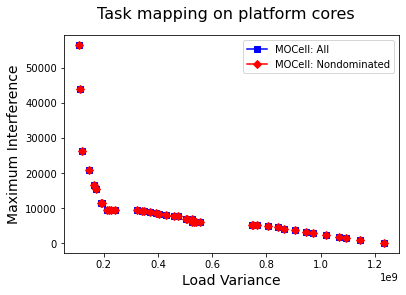

2022-03-04 10:43:35,857 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.MOCell_merged.nonDominated.csv
2022-03-04 10:43:35,857 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.MOCell_merged.nonDominated.csv
2022-03-04 10:43:35,857 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.MOCell_merged.nonDominated.csv
2022-03-04 10:43:35,865 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.MOCell_merged.nonDominated.csv
Progress: 36000it [03:38, 164.48it/s]                                                                                  


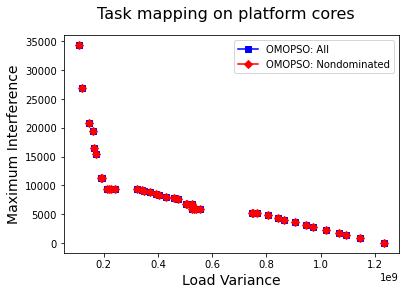

2022-03-04 10:47:52,259 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.OMOPSO_merged.nonDominated.csv
2022-03-04 10:47:52,259 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.OMOPSO_merged.nonDominated.csv
2022-03-04 10:47:52,259 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.OMOPSO_merged.nonDominated.csv
2022-03-04 10:47:52,267 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.OMOPSO_merged.nonDominated.csv
Progress: 36000it [03:09, 190.39it/s]                                                                                  


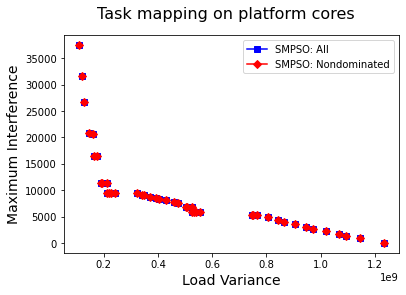

2022-03-04 10:51:39,358 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.SMPSO_merged.nonDominated.csv
2022-03-04 10:51:39,366 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.SMPSO_merged.nonDominated.csv
2022-03-04 10:51:39,368 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.SMPSO_merged.nonDominated.csv
2022-03-04 10:51:39,368 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.SMPSO_merged.nonDominated.csv
2022-03-04 10:51:39,386 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.NSGA-II.nonDominated.csv
2022-03-04 10:51:39,388 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.NSGA-II.nonDominated.csv
2022-03-04 10:51:39,388 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.MOCell.nonDominated.csv
2022-03-04 10:51:39,388 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.MOCell.nonDominated.csv
2022-03-04 10:51:39,388 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.OMOPS

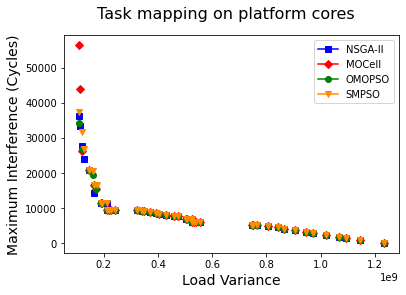

2022-03-04 10:51:40,138 [MainThread  ] [INFO ]  Output file (function values): ./FUN/FUN.Best Solutions.nonDominated.csv
2022-03-04 10:51:40,138 [MainThread  ] [INFO ]  Output file (variables): ./VAR/VAR.Best Solutions.nonDominated.csv


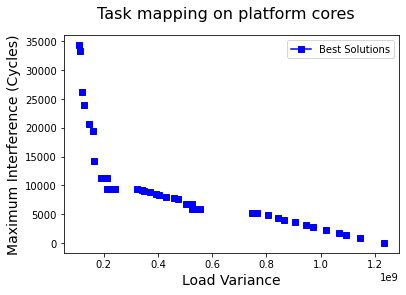

In [13]:
task_list = []
NB_TASKS = 8

PE_list = []
NB_PEs = 8

# Define periods
T1 = 1200000
T2 = 60000

# List that defines the type of PE (ARM Cortex A15 = 0; DSP C66x = 1). All the PEs are cores in this configuration.
PE_type_list = [0, 0, 1, 1, 1, 1, 1, 1] 

if(len(PE_type_list) != NB_PEs):
    print("ERROR. PE_type_list length does not match with the available number of cores (NB_PEs)")

for i in range(NB_PEs):
    PE_list.append(PE(i,PE_type_list[i],0,0))

# KEYSTONE II - task list = [rb0 rb0 rb0 rb0 sb0 sb0 rb1 rb1} - ARM Cortex A15 and DSP C66x profiling    
task_memory = [512, 512, 512, 512, 4096, 4096, 512, 512] # Implemented but not used. Random numbers have been given. 
task_load_ARM = [5110, 5110, 5110, 5110, 36315, 36315, 3107, 3107] 
task_load_DSP = [18927, 18927, 18927, 18927, 33202, 33202, 12698, 12698] 
task_access_ARM = [84, 84, 84, 84, 437, 437, 51, 51]
task_access_DSP = [304, 304, 304, 304, 443, 443, 197, 197] 
task_SP_ARM = [0.631, 0.631, 0.631, 0.631, 0.312, 0.312, 0.628, 0.628] 
task_SP_DSP = [0.514, 0.514, 0.514, 0.514, 0.298, 0.298, 0.518, 0.518] 
task_LP_ARM = [0.369, 0.369, 0.369, 0.369, 0.688, 0.688, 0.372, 0.372] 
task_LP_DSP = [0.486, 0.486, 0.486, 0.486, 0.702, 0.702, 0.482, 0.482] 
task_ACOR_ARM = [3.4, 3.4, 3.4, 3.4, 2.46, 2.46, 3.36, 3.36] 
task_ACOR_DSP = [2.2, 2.2, 2.2, 2.2, 1.7, 1.7, 2.1, 2.1] 
task_row_switches_ARM = [16, 16, 16, 16, 0, 0, 14, 14] 
task_row_switches_DSP = [16, 16, 16, 16, 0, 0, 23, 23]
task_period = [T1, T1, T1, T1, T1, T1, T1, T1]


if(len(task_load_ARM) != NB_TASKS):
    print("ERROR. task_load_ARM list length does not match with the available number of tasks (NB_TASKS)")


# Create the task list, differentiating between ARM (1st in list, i.e., 0) ad DSP (2nd in list, i.e., 1) values 
# when applicable. 
for i in range(NB_TASKS):
    task_list.append(Task(i, 
                          task_memory[i], 
                          [task_load_ARM[i], task_load_DSP[i]],
                          [task_access_ARM[i], task_access_DSP[i]],  
                          [task_SP_ARM[i], task_SP_DSP[i]], 
                          [task_LP_ARM[i], task_LP_DSP[i]], 
                          [task_ACOR_ARM[i], task_ACOR_DSP[i]], 
                          -1, # PE value is not required as it is decided during the solutions exploration
                          -1, # Bank value is not required as it is decided during the solutions exploration
                          [task_row_switches_ARM[i], task_row_switches_DSP[i]],
                          task_period[i])
                        )
    

# Initialize the platform
ptf = Platform(NB_PEs, NB_BANKS, NB_TASKS)

# Algorithms to use
#algorithm_tag_arr = ["SMPSO"]
algorithm_tag_arr = ["NSGA-II", "MOCell", "OMOPSO", "SMPSO"]
#algorithm_tag_arr = ["NSGA-II", "MOCell", "GDE3", "IBEA", "MOEAD", "SMPSO", "OMOPSO"]


algorithms_solutions_list = []

# Run the different chosen algorithms and merge level solutions for the Task Mapping
for number_of_algorithm in range((len(algorithm_tag_arr))):        
    # Select the algorith to run in this iteration
    current_algorithm_tag = algorithm_tag_arr[number_of_algorithm]
    
    # Start task/memory mapping exploration with the selected algorithm. Save solutions in algorithms_solutions_list
    algorithms_solutions_list.append(solutions_exploration(task_list, current_algorithm_tag))

    
# Figures X and Y axis tags 
axis_labels = ['Load Variance', 'Maximum Interference (Cycles)']

# Export and display all the solution from the different algorithms in a single graph 
if len(algorithm_tag_arr) > 1:
    export_results(algorithms_solutions_list, algorithm_tag_arr)
    draw_2Dgraphs(algorithms_solutions_list, algorithm_tag_arr, axis_labels, 0, "multipleSet")


# Create a flat list with all the nondominated solution from all the run algorithms 
algorithms_solutions_flat_list = []
for algorithm_sublist in algorithms_solutions_list:
    for item in algorithm_sublist:
        algorithms_solutions_flat_list.append(item)
 
# Get the final nondominated solutions considering all the algorithms nondominated solutions  
final_list_non_dominated = []
final_list_non_dominated.append(get_non_dominated_solutions(algorithms_solutions_flat_list))

# Export the nondominated solutions considering all the algorithms
export_results(final_list_non_dominated, "Best Solutions")
# Display and export the nondominated solutions considering all the algorithms
draw_2Dgraphs(final_list_non_dominated, "Best Solutions", axis_labels, 0, "absoluteSet")
